In [1]:
import os
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, Add, MaxPooling2D, GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback
from sklearn.metrics import roc_auc_score, roc_curve
import tensorflow as tf

In [2]:
def data(dataset_path):
    images = []
    labels = []
    for subfolder in os.listdir(dataset_path):
        subfolder_path = os.path.join(dataset_path, subfolder)
        if not os.path.isdir(subfolder_path):
            continue
        for image_filename in os.listdir(subfolder_path):
            if image_filename.endswith(".jpg"):
                image_path = os.path.join(subfolder_path, image_filename)
                images.append(image_path)
                labels.append(subfolder)
    df = pd.DataFrame({'image': images, 'label': labels})
    return df
# Load train, test, and validation datasets
train = data(r'C:\Users\HP\Downloads\BONEFRACTUREDATASET_SIVA.v1i.folder\train')
test = data(r'C:\Users\HP\Downloads\BONEFRACTUREDATASET_SIVA.v1i.folder\test')
valid = data(r'C:\Users\HP\Downloads\BONEFRACTUREDATASET_SIVA.v1i.folder\valid')

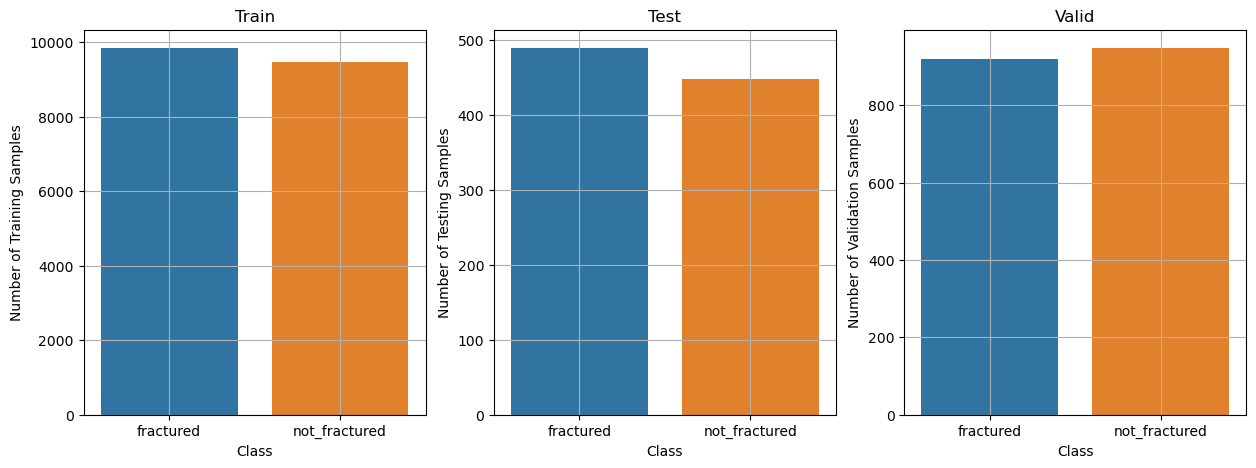

In [3]:
# Plotting class distribution
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
sns.countplot(x=train.label)
plt.xlabel("Class")
plt.ylabel("Number of Training Samples")
plt.title('Train')
plt.grid(True)
plt.subplot(1, 3, 2)
sns.countplot(x=test.label)
plt.xlabel("Class")
plt.ylabel("Number of Testing Samples")
plt.title('Test')
plt.grid(True)
plt.subplot(1, 3, 3)
sns.countplot(x=valid.label)
plt.xlabel("Class")
plt.ylabel("Number of Validation Samples")
plt.title('Valid')
plt.grid(True)
plt.show()

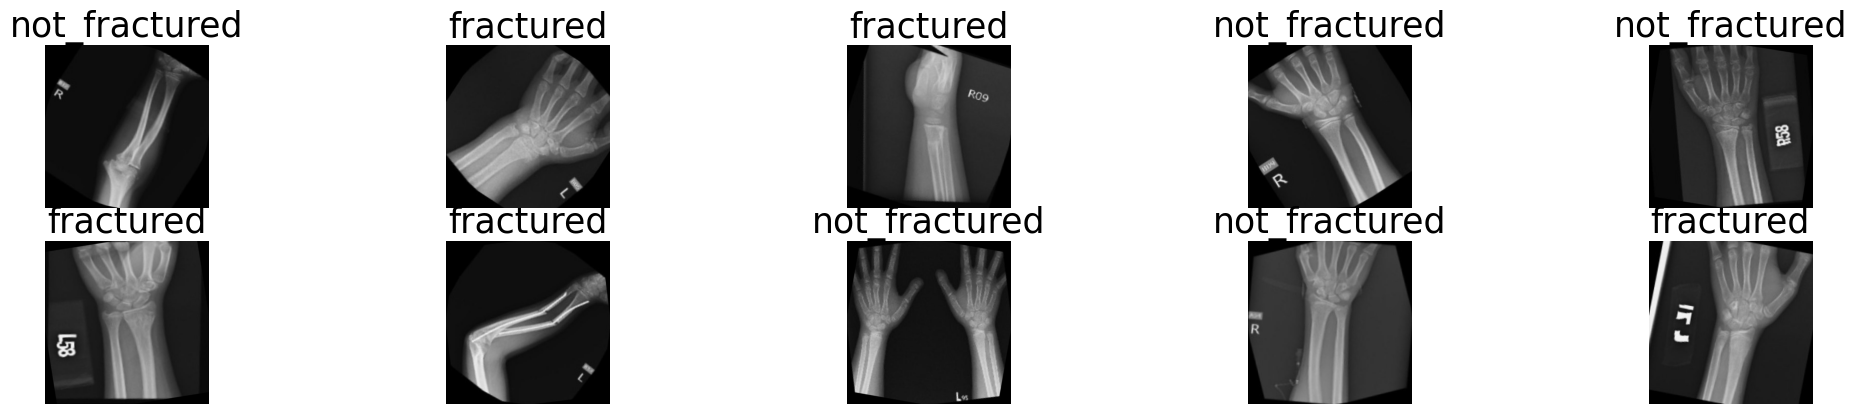

In [4]:
# Display some sample images
plt.figure(figsize=(25, 25))
for n, i in enumerate(np.random.randint(0, len(train), 10)):
    plt.subplot(10, 5, n + 1)
    img = cv2.imread(train.image[i])
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title(train.label[i], fontsize=25)

In [5]:
image_size = (224, 224)
batch_size = 32

datagen = ImageDataGenerator(rescale=1./255)
train_generator = datagen.flow_from_dataframe(
    train,
    x_col='image',
    y_col='label',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=True
)
test_generator = datagen.flow_from_dataframe(
    test,
    x_col='image',
    y_col='label',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)
valid_generator = datagen.flow_from_dataframe(
    valid,
    x_col='image',
    y_col='label',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=True
)

Found 19329 validated image filenames belonging to 2 classes.
Found 936 validated image filenames belonging to 2 classes.
Found 1868 validated image filenames belonging to 2 classes.


In [6]:
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, Add, MaxPooling2D, GlobalAveragePooling2D, Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam


def residual_block(x, filters, kernel_size=3, stride=1):
    
    shortcut = x

    
    x = Conv2D(filters, kernel_size=kernel_size, strides=stride, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    
    x = Conv2D(filters, kernel_size=kernel_size, strides=1, padding='same')(x)
    x = BatchNormalization()(x)

    
    if stride != 1 or shortcut.shape[-1] != filters:
        shortcut = Conv2D(filters, kernel_size=1, strides=stride, padding='same')(shortcut)
        shortcut = BatchNormalization()(shortcut)

    
    x = Add()([x, shortcut])
    x = Activation('relu')(x)

    return x
input_layer = Input(shape=(224, 224, 3))
x = Conv2D(32, (7, 7), strides=(2, 2), padding='same')(input_layer) 
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
x = residual_block(x, 32)
x = residual_block(x, 32)
x = residual_block(x, 64, stride=2)
x = residual_block(x, 64)
x = residual_block(x, 128, stride=2)
x = GlobalAveragePooling2D()(x)
output = Dense(1, activation='sigmoid')(x)
model = Model(inputs=input_layer, outputs=output)
model.compile(optimizer=Adam(learning_rate=0.05), loss='binary_crossentropy', metrics=['accuracy', tf.keras.metrics.AUC(name='auc')])
model.summary()



Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 112, 112, 32)         4736      ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 112, 112, 32)         128       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 112, 112, 32)         0         ['batch_normalization[0]

                                                                                                  
 activation_7 (Activation)   (None, 28, 28, 64)           0         ['batch_normalization_8[0][0]'
                                                                    ]                             
                                                                                                  
 conv2d_9 (Conv2D)           (None, 28, 28, 64)           36928     ['activation_7[0][0]']        
                                                                                                  
 batch_normalization_9 (Bat  (None, 28, 28, 64)           256       ['conv2d_9[0][0]']            
 chNormalization)                                                                                 
                                                                                                  
 add_3 (Add)                 (None, 28, 28, 64)           0         ['batch_normalization_9[0][0]'
          

In [7]:
class SpecificityAtSensitivityCallback(Callback):
    def __init__(self, val_data, sensitivity_threshold=0.95):
        super(SpecificityAtSensitivityCallback, self).__init__()
        self.val_data = val_data
        self.sensitivity_threshold = sensitivity_threshold
        self.val_specificity_at_sensitivity = 0

    def on_epoch_end(self, epoch, logs=None):
        val_preds = []
        val_true = []

        for i in range(len(self.val_data)):
            x, y = self.val_data[i]
            val_preds.extend(self.model.predict(x).ravel())
            val_true.extend(y)

        fpr, tpr, _ = roc_curve(val_true, val_preds)
        specificity = 1 - fpr
        sensitivity = tpr

        specificity_at_sensitivity = specificity[np.argmax(sensitivity >= self.sensitivity_threshold)]
        val_auc = roc_auc_score(val_true, val_preds)

        print(f"\nEpoch {epoch + 1}: val_auc = {val_auc:.4f}, val_specificity_at_sensitivity = {specificity_at_sensitivity:.4f}")

        logs['val_auc'] = val_auc
        logs['val_specificity_at_sensitivity'] = specificity_at_sensitivity

In [8]:
specificity_callback = SpecificityAtSensitivityCallback(valid_generator, sensitivity_threshold=0.95)

In [9]:
# Train the model with the custom callback
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=valid_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_steps=valid_generator.samples // batch_size,
    callbacks=[specificity_callback]
)

Epoch 1/10


1/1 [==============================] - 2s 2s/step

Epoch 1: val_auc = 0.5195, val_specificity_at_sensitivity = 0.0739
604/604 [==============================] - 1037s 2s/step - loss: 0.6373 - accuracy: 0.6210 - auc: 0.6796 - val_loss: 3.7506 - val_accuracy: 0.4935 - val_auc: 0.5195 - val_specificity_at_sensitivity: 0.0739
Epoch 2/10
1/1 [==============================] - 0s 310ms/step

Epoch 2: val_auc = 0.5980, val_specificity_at_sensitivity = 0.1533
604/604 [==============================] - 991s 2s/step - loss: 0.4359 - accuracy: 0.7905 - auc: 0.8749 - val_loss: 1.5450 - val_accuracy: 0.5399 - val_auc: 0.5980 - val_specificity_at_sensitivity: 0.1533
Epoch 3/10
1/1 [==============================] - 0s 220ms/step

Epoch 3: val_auc = 0.9045, val_specificity_at_sensitivity = 0.6772
604/604 [==============================] - 959s 2s/step - loss: 0.2823 - accuracy: 0.8786 - auc: 0.9507 - val_loss: 0.4517 - val_accuracy: 0.8330 - val_auc: 0.9045 - val_specificity_at_sensitivi

1/1 [==============================] - 0s 103ms/step

Epoch 5: val_auc = 0.9813, val_specificity_at_sensitivity = 0.9000
604/604 [==============================] - 683s 1s/step - loss: 0.1129 - accuracy: 0.9583 - auc: 0.9916 - val_loss: 0.5088 - val_accuracy: 0.8491 - val_auc: 0.9813 - val_specificity_at_sensitivity: 0.9000
Epoch 6/10
1/1 [==============================] - 0s 96ms/step

Epoch 6: val_auc = 0.9124, val_specificity_at_sensitivity = 0.7174
604/604 [==============================] - 514s 851ms/step - loss: 0.0751 - accuracy: 0.9719 - auc: 0.9960 - val_loss: 1.7870 - val_accuracy: 0.6514 - val_auc: 0.9124 - val_specificity_at_sensitivity: 0.7174
Epoch 7/10
1/1 [==============================] - 0s 97ms/step

Epoch 7: val_auc = 0.9786, val_specificity_at_sensitivity = 0.8696
604/604 [==============================] - 503s 832ms/step - loss: 0.0622 - accuracy: 0.9783 - auc: 0.9972 - val_loss: 0.4529 - val_accuracy: 0.8745 - val_auc: 0.9786 - val_specificity_at_sensitivity: 0.8

Epoch 8/10
1/1 [==============================] - 0s 99ms/step

Epoch 8: val_auc = 0.9980, val_specificity_at_sensitivity = 0.9913
604/604 [==============================] - 501s 829ms/step - loss: 0.0710 - accuracy: 0.9757 - auc: 0.9961 - val_loss: 0.4546 - val_accuracy: 0.8540 - val_auc: 0.9980 - val_specificity_at_sensitivity: 0.9913
Epoch 9/10
1/1 [==============================] - 0s 101ms/step

Epoch 9: val_auc = 0.9857, val_specificity_at_sensitivity = 0.9315
604/604 [==============================] - 502s 831ms/step - loss: 0.0298 - accuracy: 0.9904 - auc: 0.9991 - val_loss: 0.2314 - val_accuracy: 0.9316 - val_auc: 0.9857 - val_specificity_at_sensitivity: 0.9315
Epoch 10/10
1/1 [==============================] - 0s 94ms/step

Epoch 10: val_auc = 0.9948, val_specificity_at_sensitivity = 0.9739
604/604 [==============================] - 503s 833ms/step - loss: 0.0358 - accuracy: 0.9877 - auc: 0.9988 - val_loss: 0.0929 - val_accuracy: 0.9671 - val_auc: 0.9948 - val_specificity_at_

In [10]:
metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]

In [11]:
# Evaluate the model on the test set
test_loss, test_accuracy, test_auc = model.evaluate(test_generator, verbose=1)

# Print the results
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
print(f"Test AUC: {test_auc:.4f}")

30/30 [==============================] - 12s 384ms/step - loss: 0.0899 - accuracy: 0.9658 - auc: 0.9949
Test Loss: 0.0899
Test Accuracy: 96.58%
Test AUC: 0.9949


In [12]:
hist_ = pd.DataFrame(history.history)
hist_

loss  accuracy       auc  val_loss  val_accuracy   val_auc  \
0  0.637320  0.620977  0.679603  3.750596      0.493534  0.519464   
1  0.435858  0.790486  0.874909  1.545046      0.539871  0.597972   
2  0.282330  0.878634  0.950740  0.451735      0.832974  0.904540   
3  0.155682  0.940302  0.984706  0.791613      0.779634  0.978389   
4  0.112869  0.958336  0.991627  0.508791      0.849138  0.981322   
5  0.075105  0.971861  0.995992  1.787021      0.651401  0.912448   
6  0.062197  0.978287  0.997155  0.452861      0.874461  0.978650   
7  0.070992  0.975748  0.996146  0.454627      0.853987  0.998040   
8  0.029823  0.990413  0.999096  0.231395      0.931573  0.985730   
9  0.035811  0.987718  0.998812  0.092872      0.967134  0.994804   

   val_specificity_at_sensitivity  
0                        0.073913  
1                        0.153261  
2                        0.677174  
3                        0.863043  
4                        0.900000  
5                        0.717391  
6                        0.869565  
7                        0.991304  
8                        0.931522  
9                        0.973913

In [13]:
y_pred = model.predict(test_generator)
y_pred_classes = np.where(y_pred > 0.5, 1, 0)

30/30 [==============================] - 12s 382ms/step


30/30 [==============================] - 11s 347ms/step


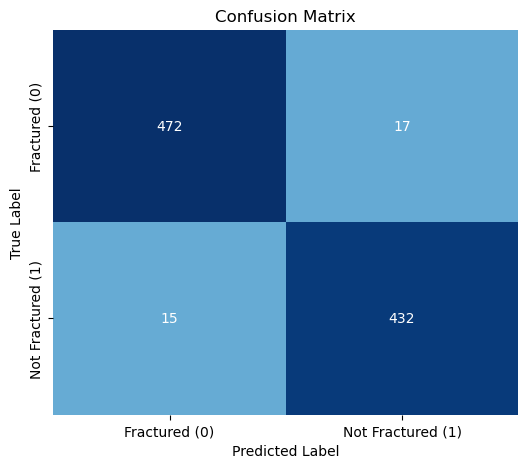

In [14]:
y_test = test_generator.labels
y_pred_probs = model.predict(test_generator)  
y_pred = (y_pred_probs > 0.5).astype(int).ravel()  
CM = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(CM, fmt='g', center=True, cbar=False, annot=True, cmap='Blues',
            xticklabels=['Fractured (0)', 'Not Fractured (1)'],
            yticklabels=['Fractured (0)', 'Not Fractured (1)'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [15]:
# Classification Report
ClassificationReport = classification_report(y_test, y_pred, target_names=['Fractured (0)', 'Not Fractured (1)'])
print('Classification Report:\n', ClassificationReport)

Classification Report:
                    precision    recall  f1-score   support

    Fractured (0)       0.97      0.97      0.97       489
Not Fractured (1)       0.96      0.97      0.96       447

         accuracy                           0.97       936
        macro avg       0.97      0.97      0.97       936
     weighted avg       0.97      0.97      0.97       936



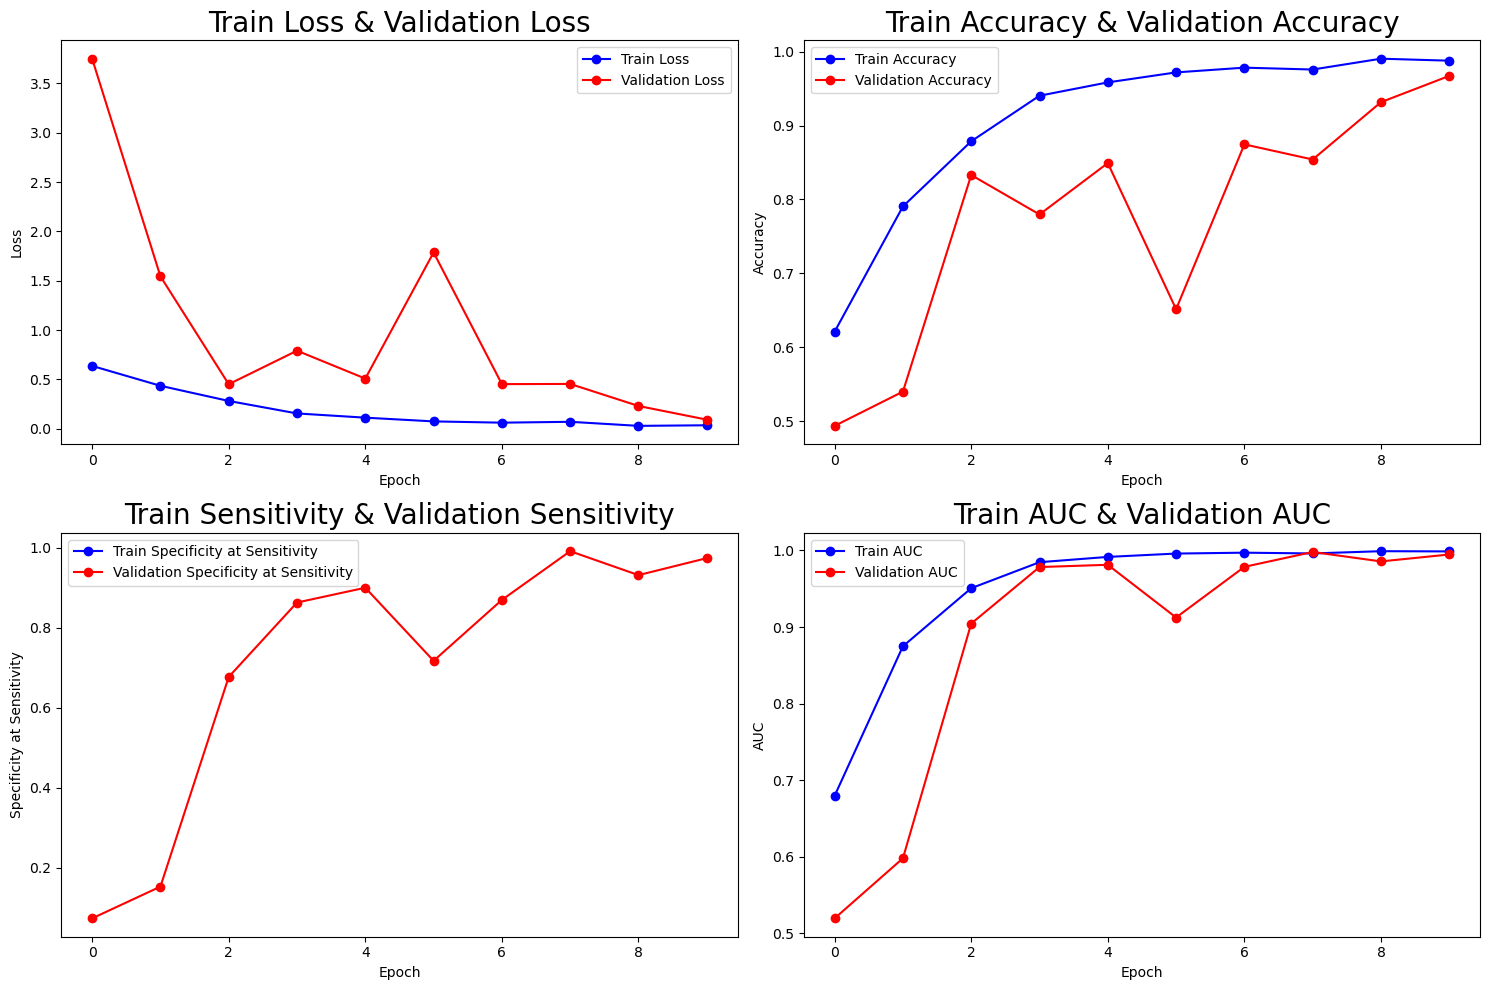

In [16]:
hist_ = history.history
plt.figure(figsize=(15, 10))
plt.subplot(2, 2, 1)
plt.plot(hist_['loss'], 'b-o', label='Train Loss')
plt.plot(hist_['val_loss'], 'r-o', label='Validation Loss')
plt.title('Train Loss & Validation Loss', fontsize=20)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.subplot(2, 2, 2)
plt.plot(hist_['accuracy'], 'b-o', label='Train Accuracy')
plt.plot(hist_['val_accuracy'], 'r-o', label='Validation Accuracy')
plt.title('Train Accuracy & Validation Accuracy', fontsize=20)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.subplot(2, 2, 3)
plt.plot(hist_.get('specificity_at_sensitivity', []), 'b-o', label='Train Specificity at Sensitivity')
plt.plot(hist_.get('val_specificity_at_sensitivity', []), 'r-o', label='Validation Specificity at Sensitivity')
plt.title('Train Sensitivity & Validation Sensitivity', fontsize=20)
plt.xlabel('Epoch')
plt.ylabel('Specificity at Sensitivity')
plt.legend()
plt.subplot(2, 2, 4)
plt.plot(hist_['auc'], 'b-o', label='Train AUC')
plt.plot(hist_['val_auc'], 'r-o', label='Validation AUC')
plt.title('Train AUC & Validation AUC', fontsize=20)
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend()
plt.tight_layout()
plt.show()

In [17]:
from sklearn.metrics import roc_curve, roc_auc_score

In [18]:
y_true = test_generator.classes
y_pred_probs = model.predict(test_generator).ravel() 
fpr, tpr, thresholds = roc_curve(y_true, y_pred_probs)
auc_score = roc_auc_score(y_true, y_pred_probs)

30/30 [==============================] - 12s 387ms/step


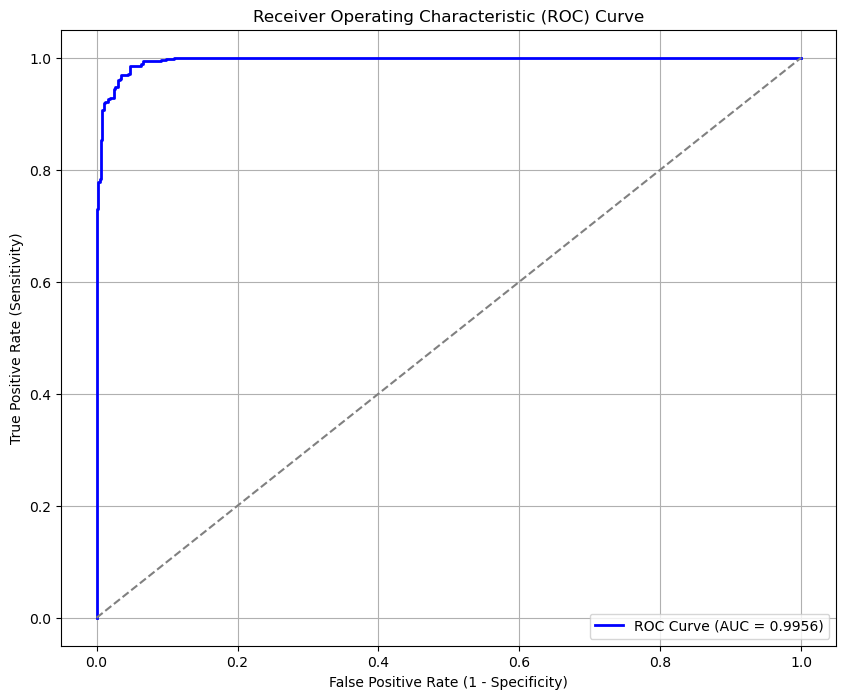

In [19]:
# Plotting the ROC Curve
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {auc_score:.4f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model  
from tensorflow.keras.applications.resnet50 import preprocess_input

In [23]:
y_test =test_generator.classes
predictions = model.predict(test_generator)
y_pred = np.where(predictions >= 0.5, 1, 0)
y_test = np.ravel(y_test)
y_pred = np.ravel(y_pred)
df = pd.DataFrame({'Actual': y_test, 'Prediction': y_pred})
df

30/30 [==============================] - 20s 660ms/step


Actual  Prediction
0         0           0
1         0           0
2         0           0
3         0           0
4         0           0
..      ...         ...
931       1           1
932       1           1
933       1           1
934       1           1
935       1           1

[936 rows x 2 columns]

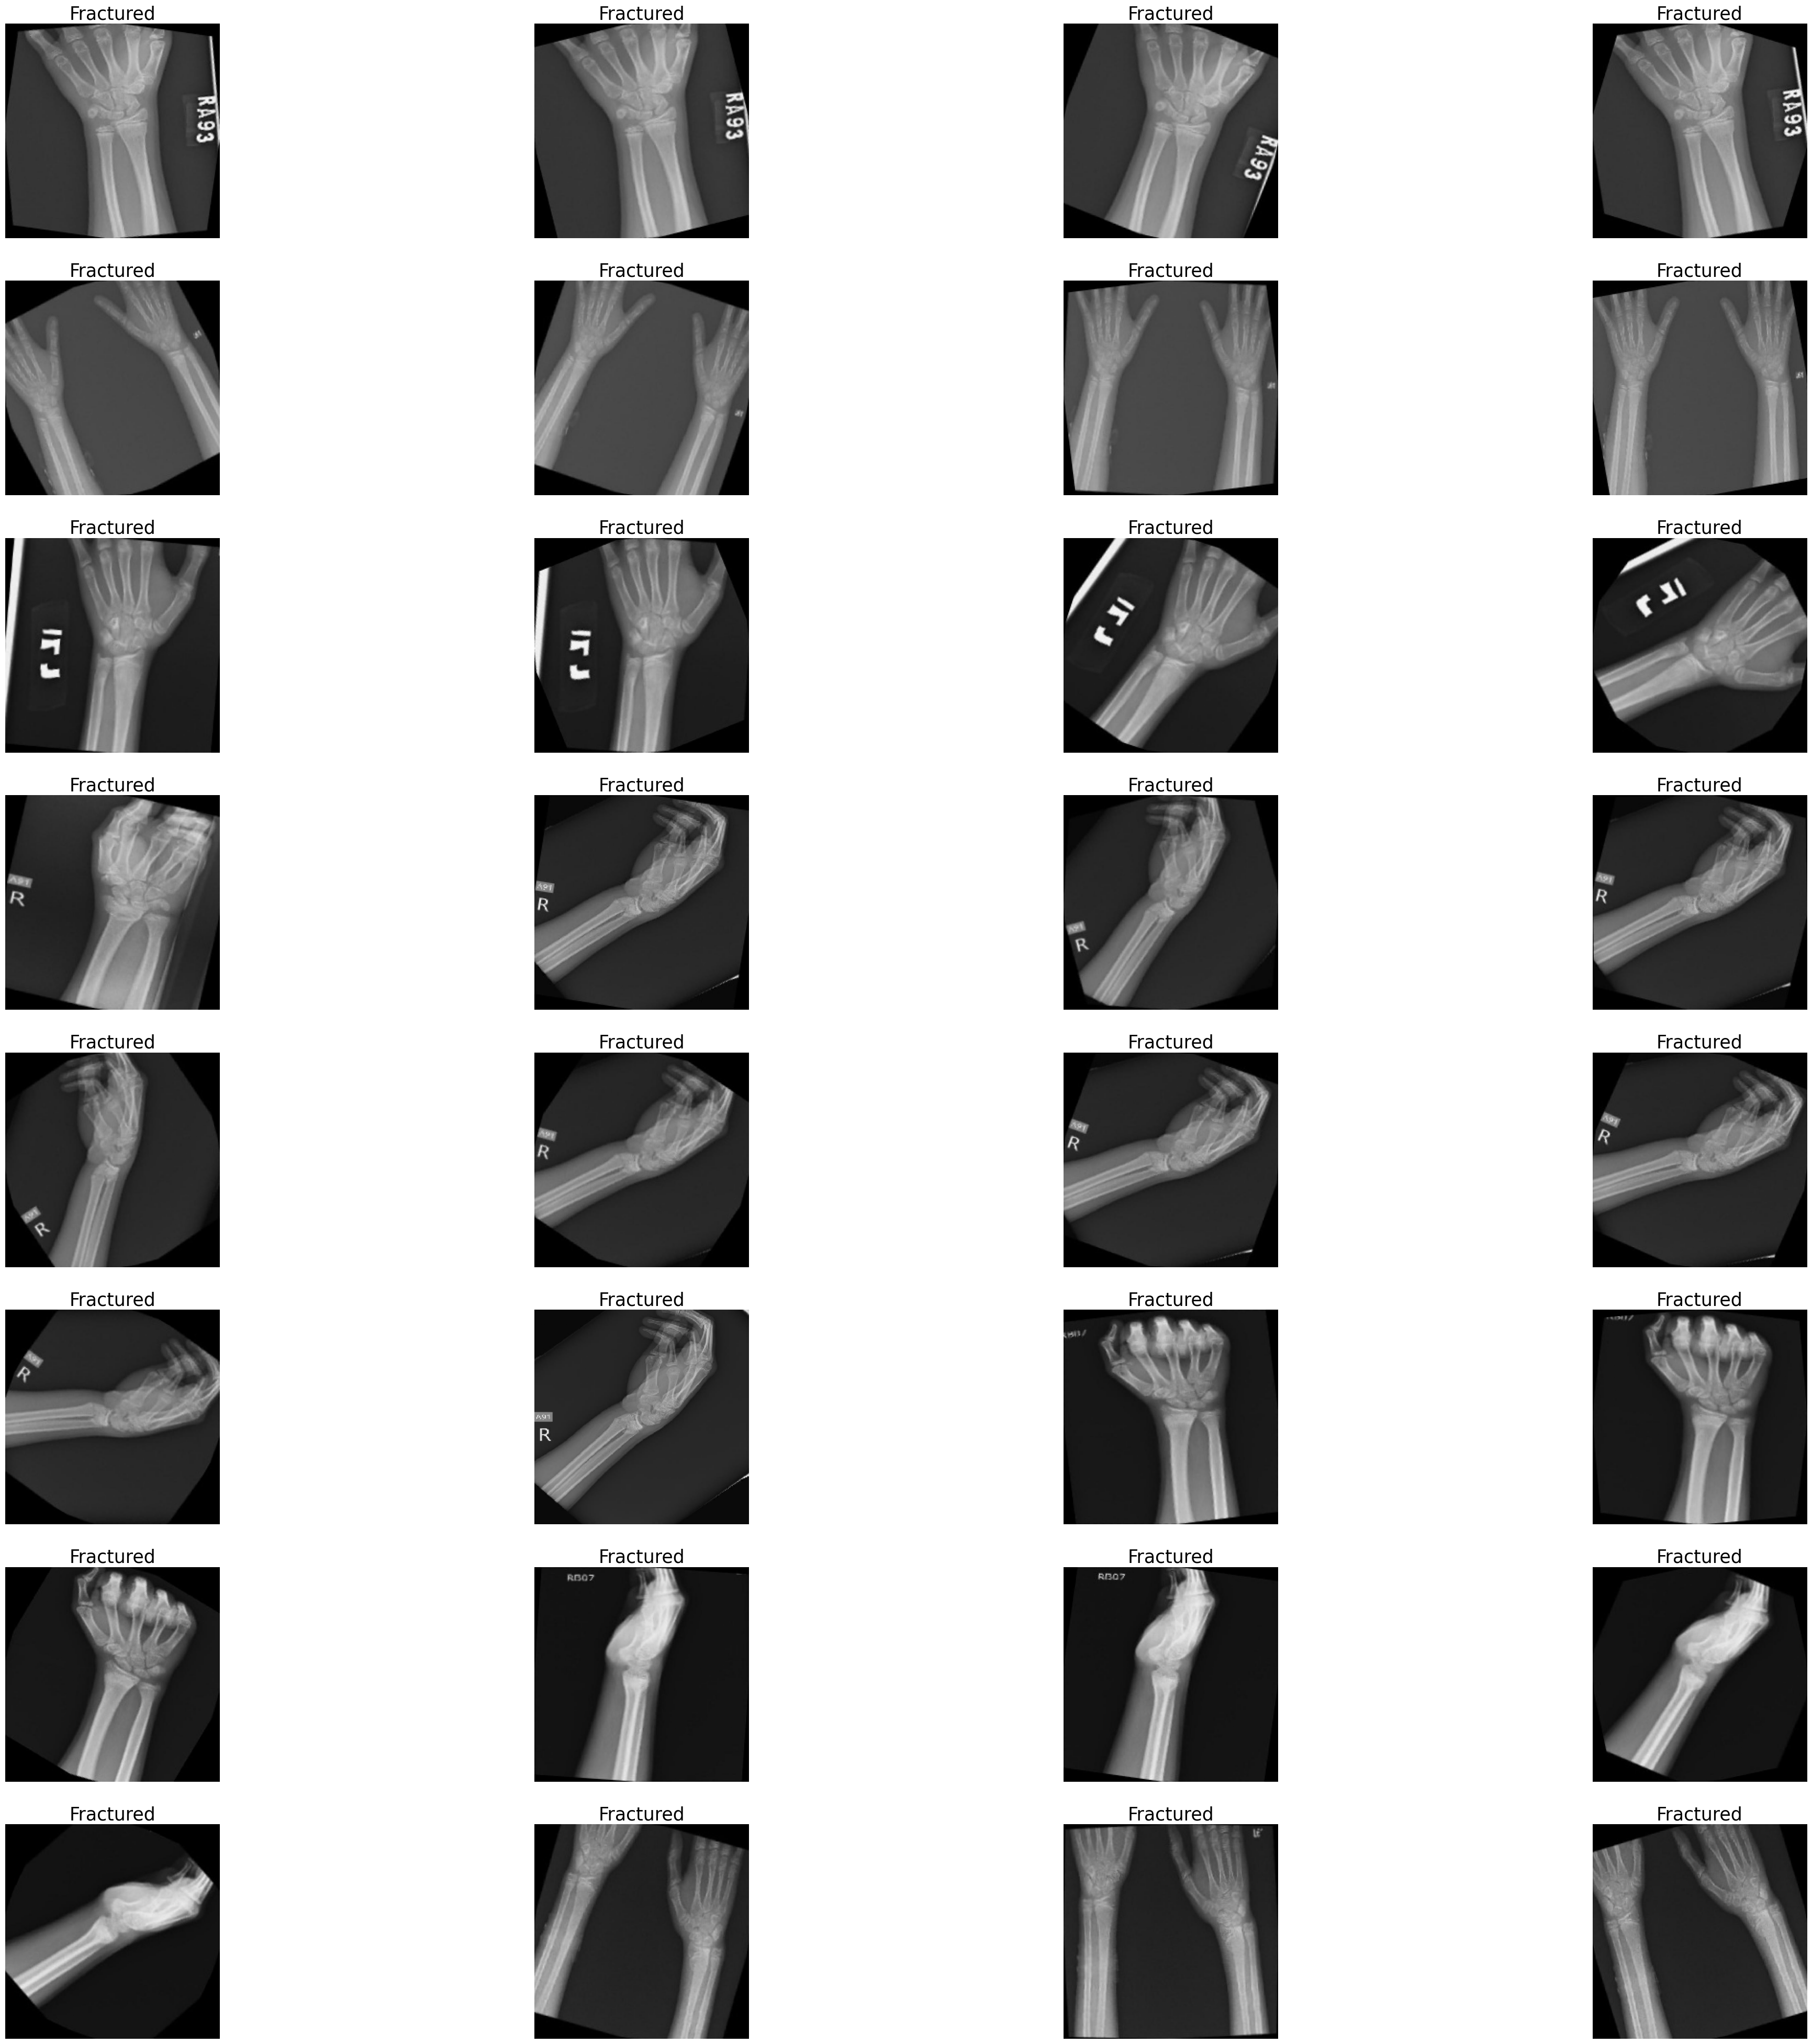

In [24]:
class_names=['Fractured', 'Not Fractured']
batch = next(test_generator)
images= batch[0]
plt.figure(figsize=(50,50))
for n in range(32):
    plt.subplot(8,4,n+1)
    plt.imshow(images[n])
    plt.axis('off')
    plt.title(class_names[int(y_test[n])],fontsize=25)

30/30 [==============================] - 21s 663ms/step


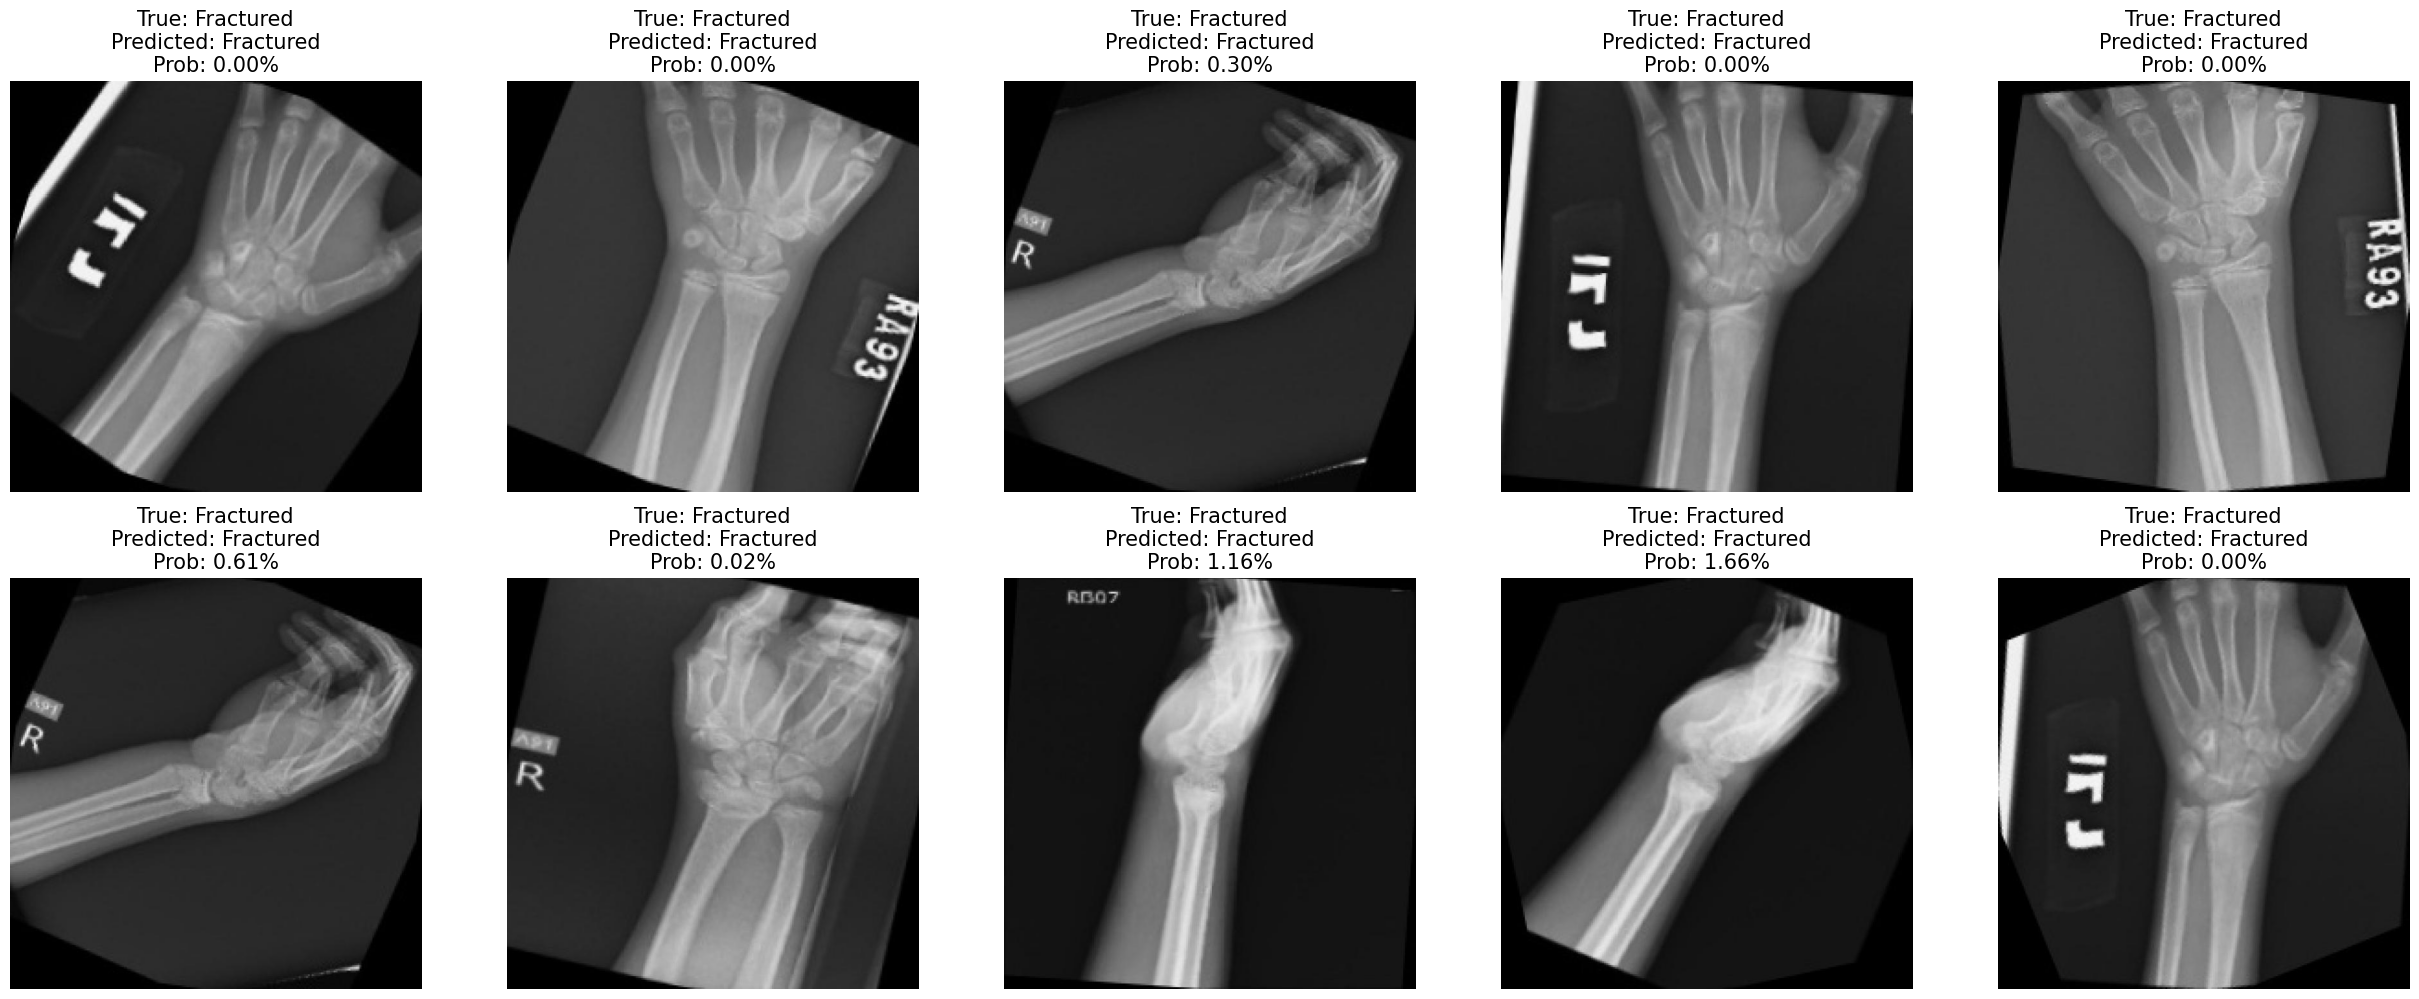

In [26]:
def display_predictions(model, test_generator, num_images=10):
    plt.figure(figsize=(25, 25))
    
    
    true_labels = test_generator.labels
    file_paths = test_generator.filepaths

    
    predictions = model.predict(test_generator).ravel()  
    predicted_classes = (predictions > 0.5).astype(int)  

   
    indices = np.random.randint(0, len(test_generator), num_images)

    for i, idx in enumerate(indices):
       
        img = cv2.imread(file_paths[idx])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  

        
        plt.subplot(num_images // 2, 5, i + 1)
        plt.imshow(img)
        plt.axis('off')

        
        true_label = "Fractured" if true_labels[idx] == 0 else "Not Fractured"
        predicted_label = "Fractured" if predicted_classes[idx] == 0 else "Not Fractured"
        probability = predictions[idx] * 100

        
        plt.title(f'True: {true_label}\nPredicted: {predicted_label}\nProb: {probability:.2f}%', fontsize=15)

    plt.tight_layout()
    plt.show()


display_predictions(model, test_generator, num_images=10)